# SuNBEaM

(S)pectral (N)on-(B)acktracking (E)mbedding (A)nd Pseudo-(M)etric, or SuNBEaM for short. The
non-backtracking matrix is a matrix representation of a graph that has deep
connections with the theory homotopy of graphs, in particular the length
spectrum function.  The eigenvalues of the non-backtracking matrix can be
effectively used to compute dissimilarity scores (or distances) between
graphs.  An old version of our manuscript can be found at the following
link.  (Newer version currently under review.)

> Leo Torres, P. Suárez Serrato, and T. Eliassi-Rad, **Graph Distance from
> the Topological View of Non-Backtracking Cycles**, preprint,
> arXiv:1807.09592 [cs.SI], (2018).

In [1]:
from sunbeam import *
import numpy as np
import networkx as nx
import matplotlib.pylab as plt

## The Non-Backtracking Matrix

The non-backtracking matrix is the (unnormalized) transition matrix of a random walker that does not backtrack, that is, it never traverses the same edge twice in succession. It can be used to, among other things, compute the number of non-backtracking walks in a graph.

The non-backtracking matrix of a cycle graph is always a permutation matrix.

In [2]:
graph = nx.cycle_graph(5)
nbm = fast_hashimoto(graph)
nbm.sum(axis=1).T, nbm.sum(axis=0)

(matrix([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]),
 matrix([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]))

The diagonal elements of powers of the non-backtracking matrix can be used to compute the number of non-backtracking cycles. For example, the trace of the cube gives the number of triangles.

In [3]:
graph = nx.erdos_renyi_graph(100, 0.1)
nbm = fast_hashimoto(graph)
directed_triangles = (nbm.dot(nbm).dot(nbm)).diagonal().sum()
undirected_triangles = sum(nx.triangles(graph).values())
directed_triangles == 2*undirected_triangles

True

## Eigenvalues

Non-backtracking cycles are topologically informative, so we wish to count how many of them exist in a graph. The above procedure gives one way to do it in the case of triangles. However, to compute larger cycles, we need the traces of higher powers of the non-backtracking matrix. These can be computed using the eigenvalues of the matrix. SuNBEAM provides this functionality.

In [ ]:
eigs = nbvals(graph, 50, fmt='2D') # Compute the largest 50 eigenvalues
plt.scatter(eigs.T[0], eigs.T[1])
plt.gca().set_aspect('equal')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.show()

Geometric features of the eigenvalue distribution in the complex plane are correlated to structural graph features. In the next plot we show the largest 200 eigenvalues of six different random graph models.

In [ ]:
from matplotlib.lines import Line2D

options = [{'color': '#1f77b4', 'label': 'Erdos-Renyi'},
           {'color': '#ff7f0e', 'label': 'Kronecker'},
           {'color': '#2ca02c', 'label': 'Barabasi-Albert'},
           {'color': '#d62728', 'label': 'Configuration Model'},
           {'color': '#9467bd', 'label': 'Watts-Strogatz'},
           {'color': '#17becf', 'label': 'Hyperbolic Graph'}]

def make_plot(data, get_xy, size=0.2):
    """Plot eigenvalue data."""
    handles = []
    for i in range(6):
        rows = data[50*i : 50*(i+1)]
        xx, yy = get_xy(rows)
        plt.scatter(xx, yy, s=size, color=options[i]['color'])
        handles.append(Line2D([], [], marker='o', markersize=8, color='w',
                              label=options[i]['label'],
                              markerfacecolor=options[i]['color']))

    plt.gca().set_aspect('equal')
    plt.legend(handles=handles)
    plt.xlabel('Real')
    plt.ylabel('Imaginary')

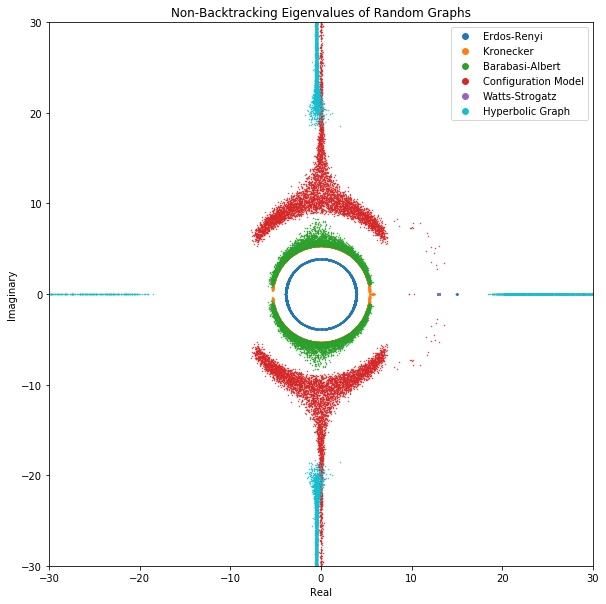

In [6]:
random_eigs = np.load('data.npy')

plt.figure(figsize=(10, 10))
make_plot(random_eigs, lambda rows: (rows[:, :200], rows[:, 200:]))
plt.xlim(-30, 30)
plt.ylim(-30, 30)
plt.title('Non-Backtracking Eigenvalues of Random Graphs')
plt.show()

## Distance

The theory of the length spectrum predicts that the eigenvalues of the non-backtracking matrix will be effective at computing distance between graphs.

In [7]:
import timeit
start = timeit.default_timer()
er = nx.erdos_renyi_graph(300, 0.05)
ba = nx.barabasi_albert_graph(300, 3)
dist1 = nbd(er, er)
dist2 = nbd(ba, ba)
dist3 = nbd(er, ba)
end = timeit.default_timer()
print("{:.3f}, {:.3f}, {:.3f}".format(dist1, dist2, dist3))
print("Elapsed time: {}".format(end - start))

0.000, 0.044, 1.434
Elapsed time: 7.474624859023606


To avoid computing the eigenvalues each time, we may pre-compute them and use the `vals` keyword as follows.

In [8]:
start = timeit.default_timer()
er_vals = nbvals(er, fmt="2D", batch=20)
ba_vals = nbvals(ba, fmt="2D", batch=20)
dist1 = nbd(er, er, vals=(er_vals, er_vals))
dist2 = nbd(ba, ba, vals=(ba_vals, ba_vals))
dist3 = nbd(er, ba, vals=(er_vals, ba_vals))
end = timeit.default_timer()
print("{:.3f}, {:.3f}, {:.3f}".format(dist1, dist2, dist3))
print("Elapsed time: {}".format(end - start))

0.000, 0.000, 1.622
Elapsed time: 1.2504457570030354


## Embedding

We also use the eigenvectors of the non-backtracking matrix in order to compute an edge embedding of a graph. That is, given a graph with $m$ edges, we compute a 2D point for each directed edge using the `nbed` function.

In [9]:
emb = nbed(ba)
print(2*ba.size(), emb.shape[0])

1782 1782


We can then visualize this embedding to understand the underlying structure of the network. Each edge in the graph is represented by two points in the following plots, one for each orientation.

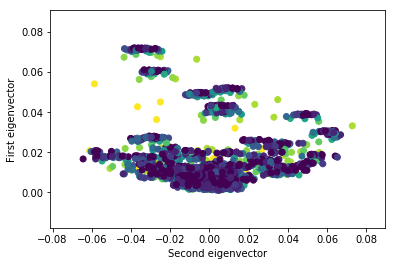

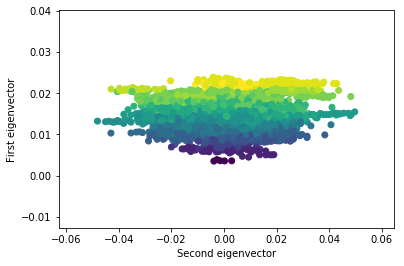

In [11]:
visualize_nbed(ba, emb=emb, color='source', log=True)
visualize_nbed(er, color='target', log=False)